### Minimizing KL Divergence

Let’s see how we could go about minimizing the KL divergence between two probability distributions using gradient descent. To begin, we create a probability distribution with a known mean (0) and variance (2). Then, we create another distribution with random parameters.

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (4,4) # Make the figures a bit bigger
plt.style.use('fivethirtyeight') 

In [3]:
import numpy as np
from scipy.stats import norm
import tensorflow as tf
import seaborn as sns
sns.set()

import math
from tqdm import tqdm

In [4]:
np.random.seed(7)

To begin, we create a probability distribution, $p$, with a known mean (0) and variance (2). 

In [5]:
x = np.arange(-10, 10, 0.1)

In [6]:
x.shape[0]

200

In [7]:
tf_pdf_shape=(1, x.shape[0])

In [8]:
p = tf.placeholder(tf.float64, shape=tf_pdf_shape)#p_pdf.shape

In [9]:
#mu = tf.Variable(np.zeros(1))
#mu = tf.Variable(tf.truncated_normal((1,), stddev=3.0))
mu = tf.Variable(np.ones(1)*5)
print(mu.dtype)
varq = tf.Variable(np.eye(1))
print(varq.dtype)
normal = tf.exp(-tf.square(x - mu) / (2 * varq))
q = normal / tf.reduce_sum(normal)

Instructions for updating:
Colocations handled automatically by placer.
<dtype: 'float64_ref'>
<dtype: 'float64_ref'>


In [10]:
learning_rate = 0.01
nb_epochs = 500*2

We define a function to compute the KL divergence that excludes probabilities equal to zero.

In [11]:
kl_divergence = tf.reduce_sum( p * tf.log(p / q))

In [12]:
kl_divergence = tf.reduce_sum(
    tf.where(p == 0, tf.zeros(tf_pdf_shape, tf.float64), p * tf.log(p / q))
)

In [13]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(kl_divergence)

In [14]:
init = tf.global_variables_initializer()

In [15]:
sess = tf.compat.v1.InteractiveSession()

In [16]:
sess.run(init)

history = []
means = []
variances = []

### Just for test

In [17]:
m1 = 0
var1 = 2
p_pdf0 = norm.pdf(x, m1, np.sqrt(var1))
p_pdf1 = 1.0 / np.sqrt(var1) / np.sqrt(2 * math.pi) * np.exp(-np.square(x - m1) / (2 * var1))

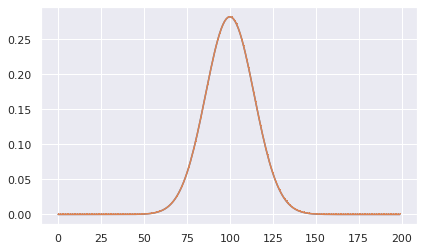

In [18]:
import matplotlib
plt.plot(p_pdf0)
plt.plot(p_pdf1, marker=",")

### KL(P||Q) !!


* $p$ : given (target)
* $q$ : variables to learn

Generating values for $p$

In [19]:
m_truth = 0
var_truth = 7

In [20]:
p_pdf0 = norm.pdf(x, m_truth, np.sqrt(var_truth))
p_pdf0 = 1.0 / np.sqrt(var_truth) / np.sqrt(2 * math.pi) * np.exp(-np.square(x - m_truth) / (2 * var_truth))
p_pdf = p_pdf0.reshape(1, -1)

In [21]:
for i in tqdm(range(nb_epochs)):
    sess.run(optimizer, { p: p_pdf })
    history.append(sess.run(kl_divergence, { p: p_pdf }))
    means.append(sess.run(mu)[0])
    variances.append(sess.run(varq)[0][0])

    if i % 100 == 10:
        print(sess.run(mu)[0], sess.run(varq)[0][0])        

 11%|█         | 107/1000 [00:00<00:01, 514.85it/s]

3.240110610816026 3.5837133740472344
0.335676301228239 4.877738470788148


 32%|███▏      | 315/1000 [00:00<00:01, 517.09it/s]

0.04580545761442576 5.254824131297897
0.006973783831366283 5.528220577818579


 47%|████▋     | 471/1000 [00:00<00:01, 514.88it/s]

0.001086973839682488 5.740628256124233
0.0001211015300097858 5.9113519404222705


 68%|██████▊   | 681/1000 [00:01<00:00, 511.13it/s]

-4.2682146749652654e-05 6.051780064376497


 78%|███████▊  | 784/1000 [00:01<00:00, 510.61it/s]

-6.734304435137489e-05 6.169249382073376
-6.694116685784831e-05 6.2687767527051586


100%|██████████| 1000/1000 [00:01<00:00, 512.27it/s]

-6.213468983510558e-05 6.3539493795592


### Plot the results

In [22]:
len1 = np.shape(means)[0]

In [23]:
alphas = np.linspace(0.1, 1, len1)
rgba_colors = np.zeros((len1,4))
# for red the first column needs to be one
rgba_colors[:,0] = 1.0
# the fourth column needs to be your alphas
rgba_colors[:, 3] = alphas

In [24]:
print(rgba_colors.shape)
grange = range(len1)
print(np.shape(grange))

(1000, 4)
(1000,)


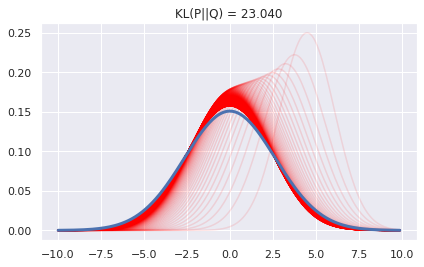

In [25]:
for mean, variance, g in zip(means, variances, grange):
    if g%5 ==0:
        q_pdf = norm.pdf(x, mean, np.sqrt(variance))
        plt.plot(x, q_pdf.reshape(-1, 1), color=rgba_colors[g])
    
plt.title('KL(P||Q) = %1.3f' % history[-1])
plt.plot(x, p_pdf.reshape(-1, 1), linewidth=3)
plt.show()

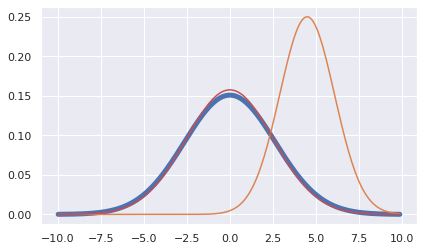

In [26]:
#target
plt.plot(x, p_pdf.reshape(-1, 1), linewidth=5)

#initial
q_pdf = norm.pdf(x, means[0] , np.sqrt(variances[0]))
plt.plot(x, q_pdf.reshape(-1, 1))

#final
q_pdf = norm.pdf(x, means[-1] , np.sqrt(variances[-1]))
plt.plot(x, q_pdf.reshape(-1, 1), color='r')

Text(0, 0.5, 'mean')

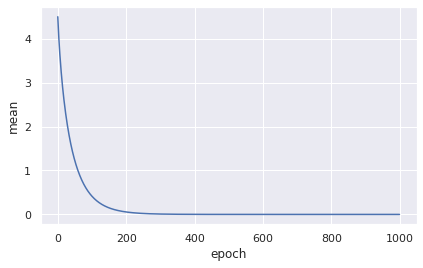

In [27]:
plt.plot(means)
plt.xlabel('epoch')
plt.ylabel('mean')

Text(0, 0.5, 'variances')

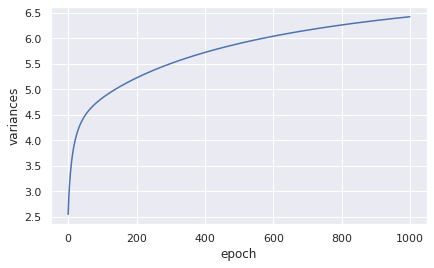

In [28]:
plt.plot(variances)
plt.xlabel('epoch')
plt.ylabel('variances')

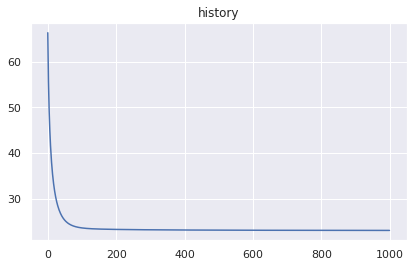

In [29]:
plt.plot(history)
plt.title('history')
plt.show()

In [30]:
#sess.close()

### Reference 

* https://towardsdatascience.com/kl-divergence-python-example-b87069e4b810